In [1]:
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
client

<Client: 'tcp://203.247.189.224:43818' processes=5 threads=90, memory=419.10 GiB>

# Import modules

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import seaborn as sns
import matplotlib.patches as patches
from scipy import stats
import cmocean
import glob
from cmcrameri import cm
from tqdm.notebook import tqdm_notebook
import warnings
warnings.simplefilter(action='ignore')
import os
import subprocess
import re
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time

# Configurations for reading data (years, vars, time_freq, ...)

In [3]:
# VAR=['U', 'V', 'PSL', 'PRECT']
# VAR=['SST']
VAR=['photoC_TOT_zint_100m']

# scenarios=('HISTsmbb','SSP370smbb','SSP370smbbext')
# members=('1011.001','1031.002','1051.003','1071.004','1091.005',
#          '1111.006','1131.007','1151.008','1171.009','1191.010')

years= list(range(1960, 2021))


LE_rootdir='/proj/jedwards/archive'
ODA_rootdir='/mnt/lustre/proj/earth.system.predictability/ASSM_EXP_timeseries/archive'


tfreq='month_1'
resolution='f09_g17'
# comp,model='atm','cam.h0'
comp,model='ocn','pop.h'
scenarios = r'\.(BHISTsmbb|BSSP370smbb)\.'

if comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

In [4]:
exceptcv=['time','lon','lat','lev', *VAR]
def process_coords(ds, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    # ds=ds.sel(lon=slice(30,120), lat=slice(-40,45)).isel(lev=25)
    # ds=ds.sel(lon=slice(0,360), lat=slice(-90,90)).isel(lev=1)
    # ds=ds.sel(lon=slice(0,360), lat=slice(-90,90))


    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [5]:
def pop_add_cyclic(da):
    #copied from Mattew Longs github (https://gist.github.com/matt-long/50433da346da8ac17cde926eec90a87c) and modified for DA
    #This doesn't work with Dask (DA should be loaded)
    #Input DA must have the name and coords (TLONG and TLAT), and don't have other dims (time etc.)
    #Output is DA
    nj = da.TLAT.shape[0]
    ni = da.TLONG.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)
    tlon = da.TLONG.data
    tlat = da.TLAT.data
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
    lon  = np.concatenate((tlon, tlon + 360.), 1)
    lon = lon[:, xL:xR]
    if ni == 320:
        lon[367:-3, 0] = lon[367:-3, 0] + 360.
    lon = lon - 360.
    lon = np.hstack((lon, lon[:, 0:1] + 360.))
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.
    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8
    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))
    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
    # copy vars
    v = da.name
    v_dims = da.dims
    # determine and sort other dimensions
    other_dims = set(v_dims) - {'nlat', 'nlon'}
    other_dims = tuple([d for d in v_dims if d in other_dims])
    lon_dim = da.dims.index('nlon')
    field = da.data
    field = np.concatenate((field, field), lon_dim)
    field = field[:, xL:xR]
    field = np.concatenate((field, field[:, 0:1]), lon_dim)
    dao = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), attrs=da.attrs)
    dao = dao.assign_coords(TLONG=TLONG)
    dao = dao.assign_coords(TLAT=TLAT)
    return dao

In [32]:
VAR='SH'
comp='wave'
FDA_rootdir = '/mnt/lustre/proj/earth.system.predictability/ATM_TEST/preliminary/ATM_ASSM_EXP/archive'
scenarios = r'\.(BHISTsmbb|BSSP370smbb)\.'
# command='ls ' + FDA_rootdir + '| grep BHISTsmbb | cut -d ''.'' -f 5-7'
command='ls ' + FDA_rootdir + '/*20p1*/wav/hist/*2019-*00000.nc'
FDA_files_raw = subprocess.check_output(command, shell=True, text=True)
FDA_files= [entry for entry in FDA_files_raw.split('\n') if entry]
FDA_files = sorted(FDA_files)

DA_ds = xr.open_mfdataset(FDA_files, 
                            combine='nested', 
                            concat_dim=['time'])

ds_clean = DA_ds.rename_dims({'NY': 'latitude', 'NX': 'longitude'})
# ds_clean = ds_clean.rename_vars({'NY': 'latitude', 'NX': 'longitude'})


ValueError: cannot rename 'NY' because it is not a variable or coordinate in this dataset

In [35]:

gridinfo = xr.open_mfdataset('/mnt/lustre/proj/earth.system.predictability/ATM_TEST/preliminary/ATM_ASSM_EXP/output/b.e21.BSSP370smbb.f09_g17.assm.projdv7.3_ba-20p1/run/wind.ww3')

In [36]:
gridinfo
grid_lat = gridinfo['gridLat']  # shape: (NY,)
grid_lon = gridinfo['gridLon']  # shape: (NX,)
ds_clean = ds_clean.assign_coords({
    'latitude': grid_lat,   # shape (50,)
    'longitude': grid_lon   # shape (90,)
})

In [37]:
ds_clean

<xarray.Dataset> Size: 33MB
Dimensions:    (time: 365, latitude: 50, longitude: 90)
Coordinates:
  * latitude   (latitude) float32 200B -78.4 -75.2 -72.0 ... 72.0 75.2 78.4
  * longitude  (longitude) float32 360B 0.0 4.0 8.0 12.0 ... 348.0 352.0 356.0
Dimensions without coordinates: time
Data variables:
    UAX        (time, latitude, longitude) float32 7MB dask.array<chunksize=(1, 50, 90), meta=np.ndarray>
    UAY        (time, latitude, longitude) float32 7MB dask.array<chunksize=(1, 50, 90), meta=np.ndarray>
    HS         (time, latitude, longitude) float32 7MB dask.array<chunksize=(1, 50, 90), meta=np.ndarray>
    TMN        (time, latitude, longitude) float32 7MB dask.array<chunksize=(1, 50, 90), meta=np.ndarray>
    THM        (time, latitude, longitude) float32 7MB dask.array<chunksize=(1, 50, 90), meta=np.ndarray>

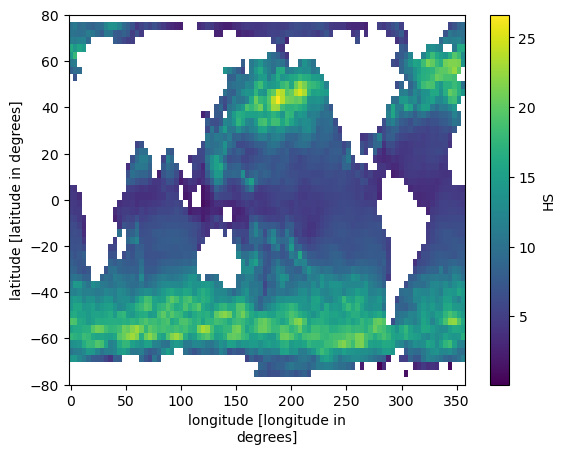

In [42]:
ds_clean['HS'].max(dim='time').plot.pcolormesh()

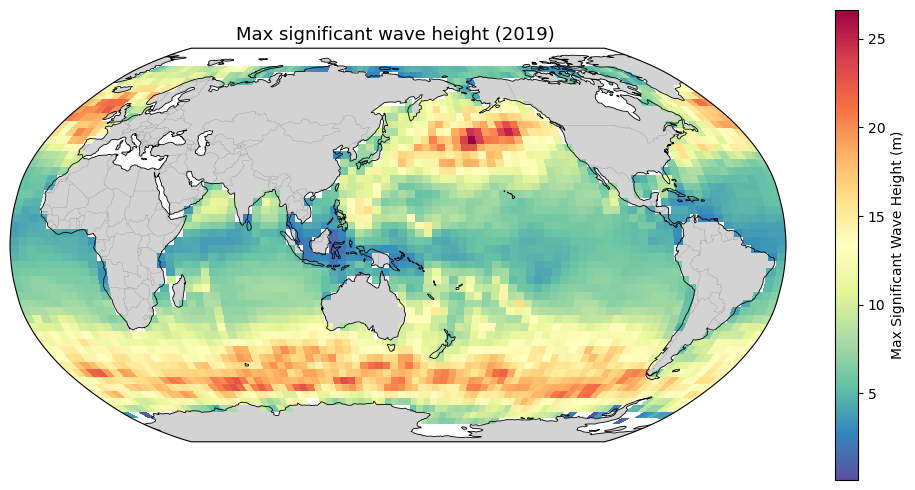

In [45]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Data: max over time
da = ds_clean['HS'].max(dim='time')  # (latitude, longitude)

# Pacific-centered Robinson projection (central longitude = 150°E)
proj = ccrs.Robinson(central_longitude=150)

# Plotting
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=proj)
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.6)
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linewidth=0.2, edgecolor='gray', zorder=1)

# Plot with shading
mesh = da.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),  # data CRS is still lat/lon
    cmap='Spectral_r',
    shading='auto',
    add_colorbar=True,
    add_labels=False
)

mesh.colorbar.set_label("Max Significant Wave Height (m)")
plt.title("Max significant wave height (2019) ", fontsize=13)
plt.tight_layout()
plt.show()


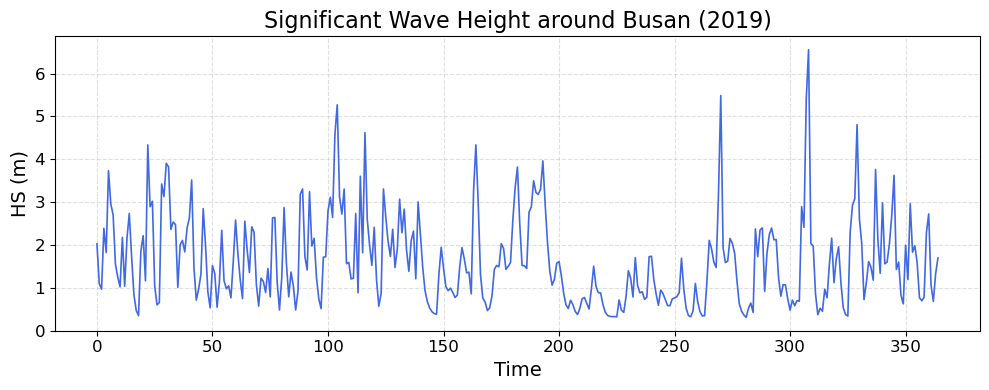

In [49]:
plt.figure(figsize=(10, 4))

busan_point.plot(linewidth=1.2, color='royalblue')

plt.title("Significant Wave Height around Busan (2019)", fontsize=16)
plt.ylabel("HS (m)", fontsize=14)
plt.xlabel("Time", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

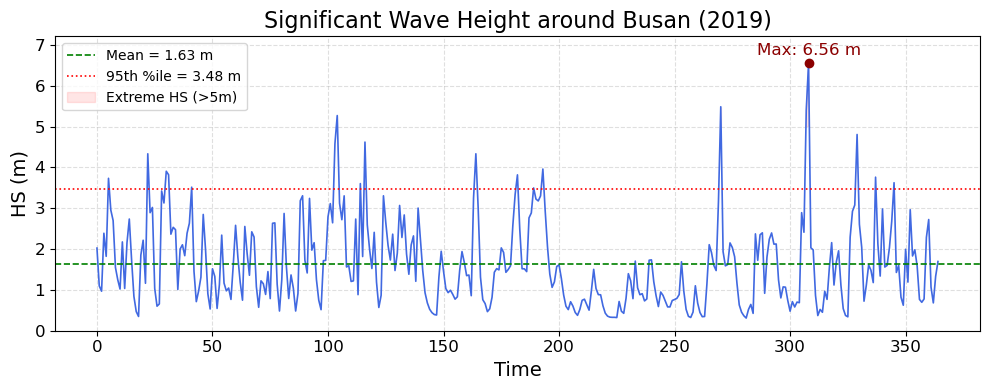

In [61]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

busan_point.plot(linewidth=1.2, color='royalblue')

# busan_point 자체는 Dask-backed → compute()
busan_point_np = busan_point.compute()

# 값만 추출
busan_values = busan_point_np.values

# 통계 기준선 계산
mean_val = busan_point_np.mean().item()
p95_val = np.percentile(busan_values, 95)
max_val = busan_values.max()
max_time = busan_point['time'].values[np.argmax(busan_values)]

# 기준선 및 주석 추가
plt.axhline(mean_val, color='green', linestyle='--', linewidth=1.2, label=f"Mean = {mean_val:.2f} m")
plt.axhline(p95_val, color='red', linestyle=':', linewidth=1.2, label=f"95th %ile = {p95_val:.2f} m")

# Max point
plt.scatter(max_time, max_val, color='darkred', zorder=5)
plt.text(max_time, max_val + 0.2, f"Max: {max_val:.2f} m", fontsize=12, ha='center', color='darkred')

# Extreme HS shading (>5m)
plt.fill_between(busan_point['time'].values, 5, busan_values,
                 where=(busan_values > 5),
                 color='red', alpha=0.1, label='Extreme HS (>5m)')

# 그래프 설정
plt.title("Significant Wave Height around Busan (2019)", fontsize=16)
plt.ylabel("HS (m)", fontsize=14)
plt.xlabel("Time", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.ylim(0, max_val * 1.1) 
plt.show()


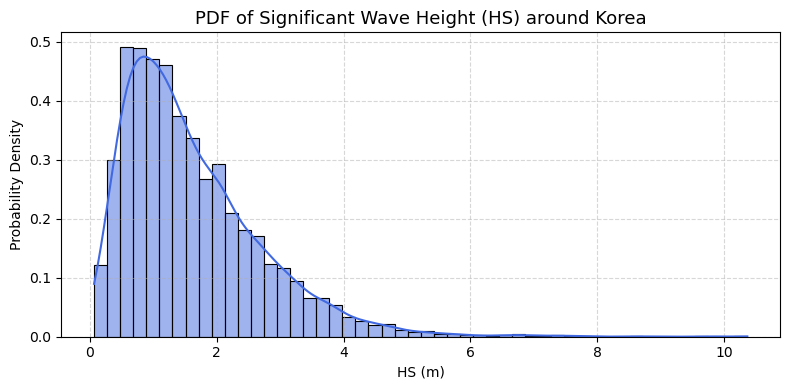

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 우리나라 주변 영역 선택
hs_korea = ds_clean['HS'].sel(
    latitude=slice(30, 40),
    longitude=slice(120, 135)
)

# 2. 시계열 + 공간 → 1D 벡터로 평탄화
hs_flat = hs_korea.values.flatten()
hs_flat = hs_flat[~np.isnan(hs_flat)]  # NaN 제거

# 3. PDF 시각화 (히스토그램 + KDE)
plt.figure(figsize=(8, 4))
sns.histplot(hs_flat, bins=50, stat='density', kde=True, color='royalblue')
plt.title("PDF of Significant Wave Height (HS) around Korea", fontsize=13)
plt.xlabel("HS (m)")
plt.ylabel("Probability Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

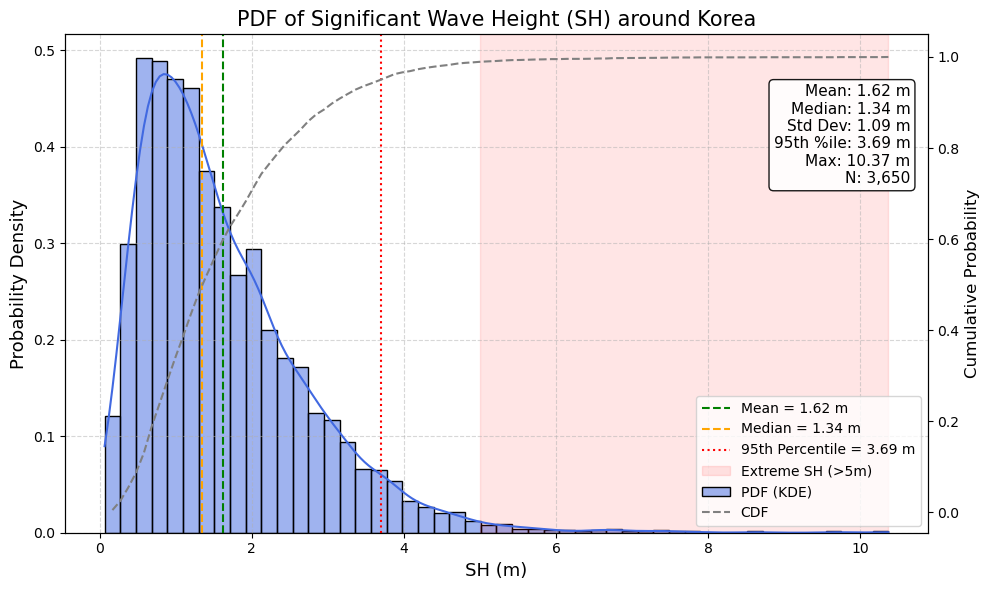

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 통계 계산
mean = np.mean(hs_flat)
median = np.median(hs_flat)
p95 = np.percentile(hs_flat, 95)
std_dev = np.std(hs_flat)
max_val = np.max(hs_flat)

# PDF + CDF plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# PDF (histogram + KDE)
sns.histplot(hs_flat, bins=50, stat='density', kde=True, color='royalblue', ax=ax1, label="PDF (KDE)")

# Statistical lines
ax1.axvline(mean, color='green', linestyle='--', linewidth=1.5, label=f'Mean = {mean:.2f} m')
ax1.axvline(median, color='orange', linestyle='--', linewidth=1.5, label=f'Median = {median:.2f} m')
ax1.axvline(p95, color='red', linestyle=':', linewidth=1.5, label=f'95th Percentile = {p95:.2f} m')

# Extreme SH shading
if max_val > 5:
    ax1.axvspan(5, max_val, color='red', alpha=0.1, label='Extreme SH (>5m)')

# CDF
counts, bin_edges = np.histogram(hs_flat, bins=100)
cdf = np.cumsum(counts) / np.sum(counts)
ax2 = ax1.twinx()
ax2.plot(bin_edges[1:], cdf, color='gray', linestyle='--', linewidth=1.5, label='CDF')
ax2.set_ylabel("Cumulative Probability", fontsize=12)

# Text box summary
textstr = '\n'.join((
    f'Mean: {mean:.2f} m',
    f'Median: {median:.2f} m',
    f'Std Dev: {std_dev:.2f} m',
    f'95th %ile: {p95:.2f} m',
    f'Max: {max_val:.2f} m',
    f'N: {len(hs_flat):,}'
))
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
ax1.text(0.98, 0.90, textstr, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Titles and labels
ax1.set_title("PDF of Significant Wave Height (SH) around Korea", fontsize=15)
ax1.set_xlabel("SH (m)", fontsize=13)
ax1.set_ylabel("Probability Density", fontsize=13)
ax1.grid(True, linestyle='--', alpha=0.5)

# Combine legends and place
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# PDF-related legends → 오른쪽 아래
leg1 = ax1.legend(lines_1, labels_1, loc='lower right', fontsize=10)

# # CDF legend → 오른쪽 중앙
# leg2 = ax2.legend(lines_2, labels_2, loc='center right', fontsize=10)

# Combine legends from both axes and show only one legend (bottom right)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right', fontsize=10)


plt.tight_layout()
plt.show()


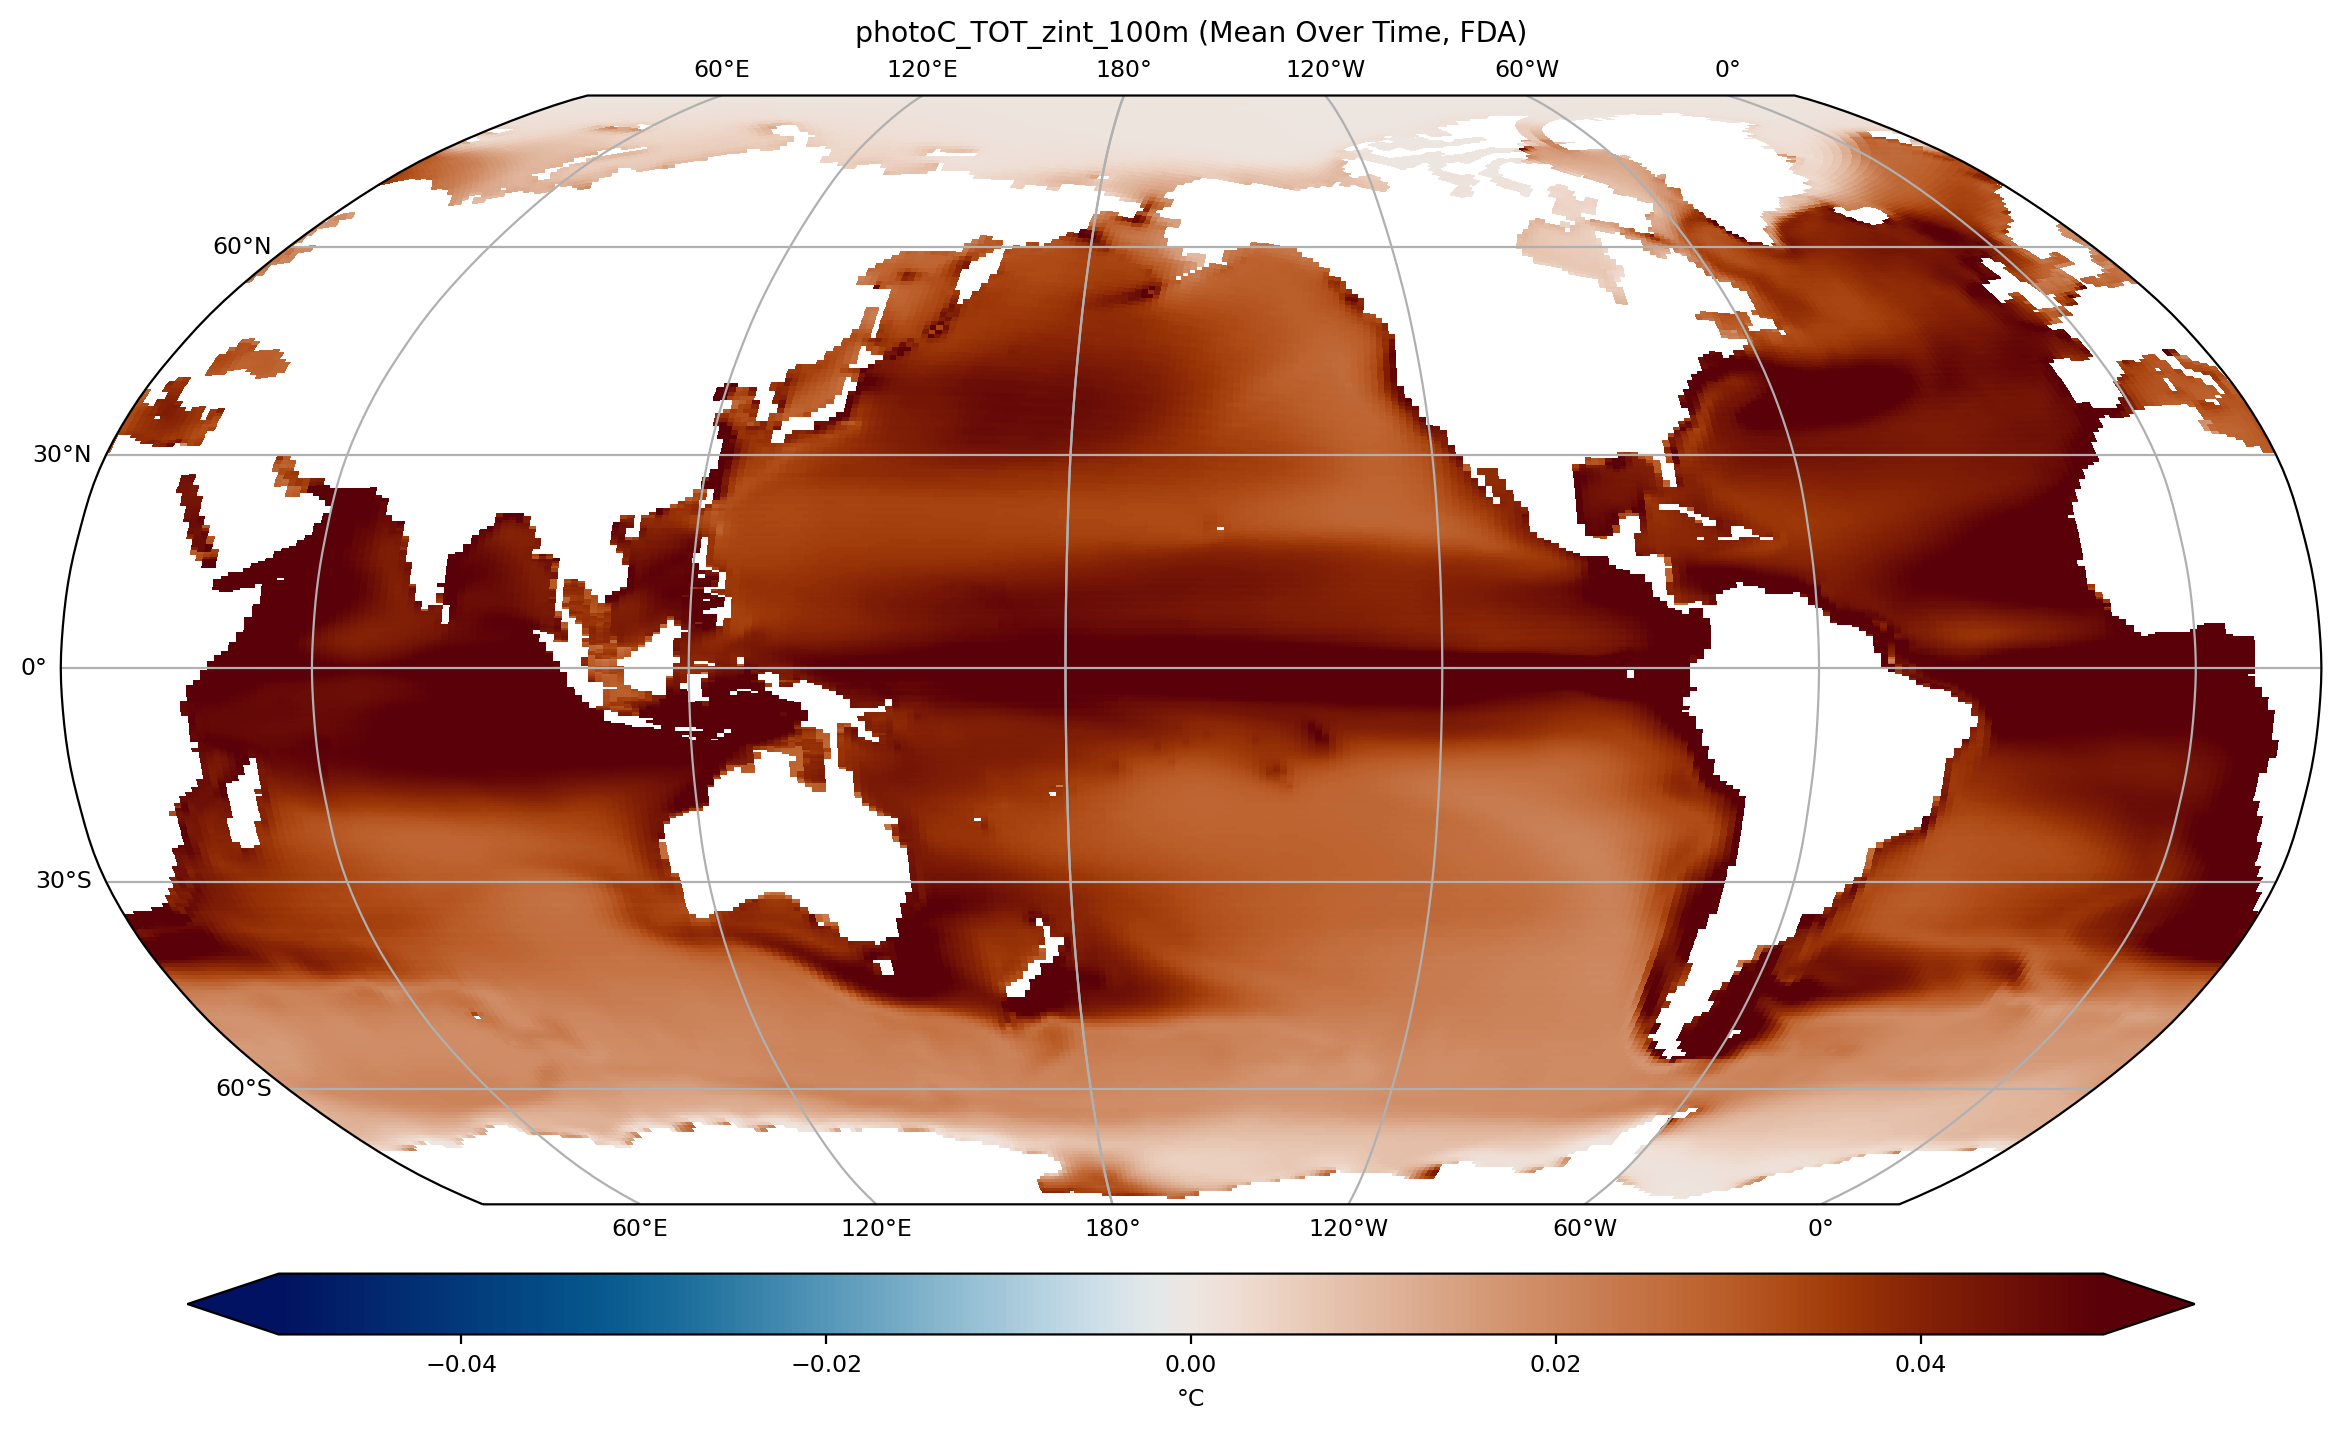

In [359]:
varn=VAR #example
# FDA_ds['name']=VAR
# FDA_ds = FDA_ds.drop_vars('name')
# FDA_ds.attrs['name'] = VAR
# for varn in VAR:

# data_array=FDA_ds[VAR].isel(concat_dim=0).mean(dim='time')

# ssh = da1.SSH.mean('time').load()

data_array=FDA_ds[VAR].mean(dim='concat_dim').mean(dim='time')
if varn == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT

data_array.attrs['name'] = VAR
# data_array.isel(concat_dim=0).isel(time=0).plot()



projection = ccrs.Robinson(central_longitude=200)

plt.rcParams.update({'font.size': 8.5})
fig, ax2 = plt.subplots(1, 1, figsize=(18.5, 9), dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':'°C', 'aspect':33, 'extend': 'both'}
# plt1=data_array.isel(concat_dim=0).mean(dim='time').plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmax=30, vmin=0, cmap=cmocean.cm.deep, cbar_kwargs=cbar_kwargs)
# plt1=data_array.plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmax=1, vmin=-1, cmap=cmocean.cm.deep, cbar_kwargs=cbar_kwargs)
if comp=='ocn' or comp=='ice':
    plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=0.05, vmin=-0.05,cmap=cm.vik, cbar_kwargs=cbar_kwargs)
else:
    plt1=data_array.isel(concat_dim=0).mean(dim='time').plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmax=30, vmin=0, cmap=cmocean.cm.deep, cbar_kwargs=cbar_kwargs)


ax2.set_title(f'{varn} (Mean Over Time, FDA)')
# ax2.coastlines()
ax2.gridlines(draw_labels=True) 
# ax2.gridlines() 

ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

# cb=plt.colorbar(plt1, pad=0.01, shrink=0.8, aspect= 35, 'extend':'neither', 'orientation':'horizontal')
# cb.set_label('mm/day',fontsize=16)
# cb.ax.tick_params(labelsize=16)

plt.show()
